In [34]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import numpy as np
from nilearn.image import load_img, math_img, new_img_like, concat_imgs, mean_img, index_img
from nilearn import plotting
import matplotlib.pyplot as plt
from functools import lru_cache
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut, cross_val_score, cross_val_predict
from sklearn.utils import parallel_backend
from scipy.ndimage import binary_dilation
from scipy.spatial.distance import squareform
from scipy.spatial.distance import cdist
from scipy.stats import rankdata, ttest_ind, ttest_rel
from matplotlib.patches import Rectangle

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams.update({'font.size': 12})
%matplotlib inline

In [35]:
import gc
gc.collect()

393

Load Data

In [36]:
# base_path = '/Users/ari/mnt/cbica-cluster/project'
project_dir = '/Users/ari/GraphLearn'
# project_dir = '/Volumes/GraphLearning'

data_dir = f'{project_dir}/data'

In [37]:
from roi_loader import Loader
loader = Loader(project_dir)

from graphs import (
    modular,
    ring_lattice,
    graph_df,
    subjects,
    subjects_lattice,
    subjects_modular
)

# Load Results

In [38]:
modular_offdiag_on = nx.to_numpy_array(modular)
modular_offdiag_off = 1 - nx.to_numpy_array(modular) - np.eye(15)

lattice_offdiag_on = nx.to_numpy_array(ring_lattice)
lattice_offdiag_off = 1 - nx.to_numpy_array(ring_lattice) - np.eye(15)

In [39]:
subjects = {}
subjects['all'] = ['GLS003', 'GLS004', 'GLS005', 'GLS006',
                   'GLS008', 'GLS009', 'GLS010', 'GLS011',
                   'GLS013', 'GLS014', 'GLS017', 'GLS018',
                   'GLS019', 'GLS020', 'GLS021', 'GLS022',
                   'GLS023', 'GLS024', 'GLS025', 'GLS026',
                   'GLS027', 'GLS028', 'GLS030', 'GLS033',
                   'GLS037', 'GLS038', 'GLS039', 'GLS040',
                   'GLS043', 'GLS044', 'GLS045']
graph = [['GLS003', 'Modular'], ['GLS004', 'Modular'], ['GLS005', 'Lattice'],
         ['GLS006', 'Lattice'], ['GLS008', 'Modular'], ['GLS009', 'Lattice'],
         ['GLS010', 'Modular'], ['GLS011', 'Modular'], ['GLS013', 'Modular'],
         ['GLS014', 'Lattice'], ['GLS016', 'Modular'], ['GLS017', 'Lattice'],
         ['GLS018', 'Modular'], ['GLS019', 'Modular'], ['GLS020', 'Lattice'],
         ['GLS021', 'Lattice'], ['GLS022', 'Modular'], ['GLS023', 'Modular'],
         ['GLS024', 'Lattice'], ['GLS025', 'Modular'], ['GLS026', 'Modular'],
         ['GLS027', 'Lattice'], ['GLS028', 'Lattice'], ['GLS030', 'Lattice'],
         ['GLS033', 'Lattice'], ['GLS034', 'Lattice'], ['GLS036', 'Modular'],
         ['GLS037', 'Modular'], ['GLS038', 'Modular'], ['GLS039', 'Modular'],
         ['GLS040', 'Lattice'], ['GLS041', 'Lattice'], ['GLS043', 'Lattice'],
         ['GLS044', 'Modular'], ['GLS045', 'Lattice'],
         ]
graph_dict = {}
for (s, g) in graph:
    if s in subjects['all']:
        graph_dict[s] = g
graph_df = pd.DataFrame(graph, columns=['Subject', 'Graph'])
graph_df = graph_df[graph_df.Subject.isin(subjects['all'])]

print('All Subjects:')
print(graph_df)

subjects['Modular'] = list(graph_df[graph_df.Graph == 'Modular'].Subject.values)
subjects['Lattice'] = list(graph_df[graph_df.Graph == 'Lattice'].Subject.values)

print('Modular:')
print(subjects['Modular'])

print('Lattice:')
print(subjects['Lattice'])

All Subjects:
   Subject    Graph
0   GLS003  Modular
1   GLS004  Modular
2   GLS005  Lattice
3   GLS006  Lattice
4   GLS008  Modular
5   GLS009  Lattice
6   GLS010  Modular
7   GLS011  Modular
8   GLS013  Modular
9   GLS014  Lattice
11  GLS017  Lattice
12  GLS018  Modular
13  GLS019  Modular
14  GLS020  Lattice
15  GLS021  Lattice
16  GLS022  Modular
17  GLS023  Modular
18  GLS024  Lattice
19  GLS025  Modular
20  GLS026  Modular
21  GLS027  Lattice
22  GLS028  Lattice
23  GLS030  Lattice
24  GLS033  Lattice
27  GLS037  Modular
28  GLS038  Modular
29  GLS039  Modular
30  GLS040  Lattice
32  GLS043  Lattice
33  GLS044  Modular
34  GLS045  Lattice
Modular:
['GLS003', 'GLS004', 'GLS008', 'GLS010', 'GLS011', 'GLS013', 'GLS018', 'GLS019', 'GLS022', 'GLS023', 'GLS025', 'GLS026', 'GLS037', 'GLS038', 'GLS039', 'GLS044']
Lattice:
['GLS005', 'GLS006', 'GLS009', 'GLS014', 'GLS017', 'GLS020', 'GLS021', 'GLS024', 'GLS027', 'GLS028', 'GLS030', 'GLS033', 'GLS040', 'GLS043', 'GLS045']


## Matrices to transform shapes and movements

In [40]:
node_to_shape = dict()  # [shape0, shape1, etc]
shape_to_node = dict()
node_to_shape_square = dict()
shape_to_node_square = dict()
for subject in subjects['all']:
    filename = f'{data_dir}/sub-{subject}/ses-2/func/sub-{subject}_ses-2_task-graphrepresentation_run-1_events.tsv'
    data = pd.read_csv(filename, sep ='\t')
    node_to_shape[subject] = data.groupby('shape', sort=True)['node'].first().values
    shape_to_node[subject] = np.argsort(node_to_shape[subject])
    node_to_shape_square[subject] = squareform(squareform(range(105))[node_to_shape[subject], :][:, node_to_shape[subject]])
    shape_to_node_square[subject] = squareform(squareform(range(105))[shape_to_node[subject], :][:, shape_to_node[subject]])

In [41]:
movement_order = [
    '[10000]',
    '[01000]',
    '[00100]',
    '[00010]',
    '[00001]',
    '[11000]',
    '[01100]',
    '[00110]',
    '[00011]',
    '[10100]',
    '[01010]',
    '[00101]',
    '[10010]',
    '[01001]',
    '[10001]',
]
node_to_movement = dict()
movement_to_node = dict()
node_to_movement_square = dict()
movement_to_node_square = dict()
for subject in subjects['all']:
    filename = f'{data_dir}/sub-{subject}/ses-2/func/sub-{subject}_ses-2_task-graphrepresentation_run-1_events.tsv'
    data = pd.read_csv(filename, sep ='\t')
    node_to_movement[subject] = data.groupby('movement_correct', sort=True)['node'].first()[movement_order].values
    movement_to_node[subject] = np.argsort(node_to_movement[subject])
    node_to_movement_square[subject] = squareform(squareform(range(105))[node_to_movement[subject], :][:, node_to_movement[subject]])
    movement_to_node_square[subject] = squareform(squareform(range(105))[movement_to_node[subject], :][:, movement_to_node[subject]])

In [42]:
results = dict()
rois = [
        'loc-localized-lh-200',
        'loc-localized-both-600',
        'postcentral-lh', 
        'postcentral-both', 
        'precentral-lh'
        ]
method = 'block'
subtract_mean = False
rescale = False
# First, load all inital results
for subject in subjects['all']:
    for roi in rois:
        data = np.load(f'{project_dir}/derived/crossval_euclidean_mats/sub-{subject}/sub-{subject}_rescale-{rescale}_subtract-mean-{subtract_mean}_cross-val-euclidean-squared_{roi}_zstats_{method}-avg.npy')
        results[(subject, roi, method, 'node')] = data
# Next, compute shape and movement orderings
for subject in subjects['all']:
    for roi in rois:
        results[(subject, roi, 'block', 'shape')] = results[(subject, roi, 'block', 'node')][node_to_shape[subject], :][:, node_to_shape[subject]]
        results[(subject, roi, 'block', 'movement')] = results[(subject, roi, 'block', 'node')][node_to_movement[subject], :][:, node_to_movement[subject]]

In [43]:
for subject in subjects['all']:
    for roi in rois:
        for ordering in ['node', 'shape', 'movement']:
            results[(subject, roi, 'offdiag-max', ordering)] = results[(subject, roi, 'block', ordering)] / np.max(results[(subject, roi, 'block', ordering)][np.where(1 - np.eye(15))])

In [44]:
results_mean = dict()
for roi in rois:
    for method in ['block', 'offdiag-max']:
        for graph in ['Modular', 'Lattice', 'all']:
            for ordering in ['node', 'shape', 'movement']:
                results_mean[(roi, method, graph, ordering)] = np.mean([results[(subject, roi, method, ordering)] for subject in subjects[graph]], 0)

In [45]:
sns.set()

# Split Representational Similarity Matrices

## Fig. 3c

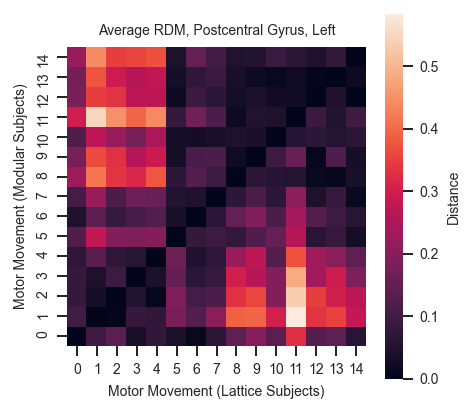

In [13]:
# sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc={'font.family': ['sans-serif'],
                             'font.sans-serif': ['Helvetica'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'legend.title_fontsize': 7}) 

method = 'offdiag-max'

triu = np.triu(np.ones((15, 15)), 0)
tril = np.tril(np.ones((15, 15)), -1)

roi = 'postcentral-lh'
ordering = 'movement'

f, ax = plt.subplots(figsize=(3.35, 3.35))
modular_lower = results_mean[(roi, method, 'Modular', ordering)] * tril
lattice_upper = results_mean[(roi, method, 'Lattice', ordering)] * triu
# modular_lower[np.where(np.eye(15))] = np.nan
# lattice_upper[np.where(np.eye(15))] = np.nan

sns.heatmap(modular_lower + lattice_upper, ax=ax, square=True, 
            cbar_kws={'label': 'Distance'},
            vmin=0,
#                     cmap=pal,
#                     vmin=vmin, vmax=vmax,
#                     center=0
           )
ax.set_title(f'Average RDM, Postcentral Gyrus, Left')
ax.invert_yaxis()
ax.set_ylabel(f'Motor Movement (Modular Subjects)')
ax.set_xlabel(f'Motor Movement (Lattice Subjects)')
# f.tight_layout()
f.savefig('images/RDM_Postcentral.pdf')

## Fig 4c

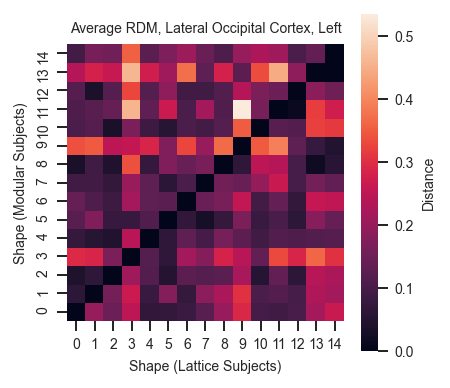

In [14]:
sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc={'font.family': ['sans-serif'],
                             'font.sans-serif': ['Helvetica'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'legend.title_fontsize': 7}) 

method = 'offdiag-max'
# method = 'block'

triu = np.triu(np.ones((15, 15)), 1)
tril = np.tril(np.ones((15, 15)), -1)

roi = 'loc-localized-lh-200'
ordering = 'shape'

f, ax = plt.subplots(figsize=(3.1, 3.1))
modular_lower = results_mean[(roi, method, 'Modular', ordering)] * tril
lattice_upper = results_mean[(roi, method, 'Lattice', ordering)] * triu
# modular_lower[np.where(np.eye(15))] = np.nan
# lattice_upper[np.where(np.eye(15))] = np.nan

sns.heatmap(modular_lower + lattice_upper, ax=ax, square=True, 
#             cbar_kws={'label': 'Mean Similarity Matrix, LOC, Left'},
            cbar_kws={'label': 'Distance'},
            vmin=0,
#                     cmap=pal,
#                     vmin=vmin, vmax=vmax,
#                     center=0
           )
ax.set_title(f'Average RDM, Lateral Occipital Cortex, Left')
ax.invert_yaxis()
ax.set_ylabel(f'Shape (Modular Subjects)')
ax.set_xlabel(f'Shape (Lattice Subjects)')
# f.tight_layout()
f.savefig('images/RDM_LOC.pdf')

## Stats: Test for finger difference effect

<Axes: >

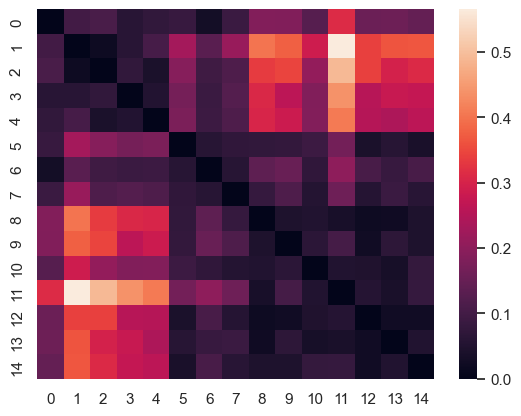

In [13]:
rdm = results_mean[('postcentral-lh', 'offdiag-max', 'all', 'movement')]
sns.heatmap(rdm)

In [14]:
f1 = rdm[np.where(np.triu(np.ones((5, 5)), 1))]
f1v2 = rdm[:5, 5:].flatten()
f2 = rdm[5:, 5:][np.where(np.triu(np.ones((10, 10)), 1))]

<Axes: >

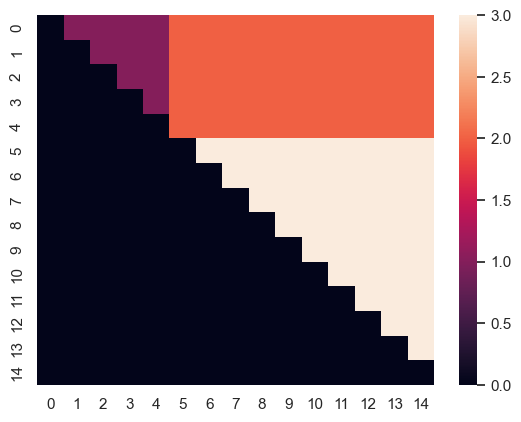

In [31]:
rdm_ex = np.zeros((15,15))
rdm_ex[np.where(np.triu(np.ones((5, 5)), 1))] = 1.0
rdm_ex[:5, 5:] = 2.0
rdm_ex[5:, 5:][np.where(np.triu(np.ones((10, 10)), 1))] = 3.0
sns.heatmap(rdm_ex)

In [15]:
ttest_ind(f1v2, f1)

Ttest_indResult(statistic=4.695825531157248, pvalue=1.6702615024343865e-05)

In [32]:
print(f"dof={len(f1v2) + len(f1) - 2}")

dof=58


In [18]:
ttest_ind(f1v2, f2)

Ttest_indResult(statistic=9.451550628385174, pvalue=2.9592024631160586e-15)

In [33]:
print(f"dof={len(f1v2) + len(f2) - 2}")

dof=93


# Fig 5c: Inter- and Intrapattern Distance

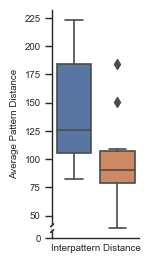

In [49]:
dfs = []
for roi in ['loc-localized-both-600']:
    for graph in ['Modular', 'Lattice']:
        offdiag = [squareform(results[(subject, roi, 'block', 'node')]).mean() for subject in subjects[graph]]
        dfs.append(pd.DataFrame(dict(values=offdiag, graph=graph, roi=roi)))
df = pd.concat(dfs)

sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc={'font.family': ['sans-serif'],
                             'font.sans-serif': ['Ariel'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'legend.title_fontsize': 7}) 
axis_color = "#2B2B2B"
g = sns.catplot(data=df,
            x='graph',
            y='values',
            col='roi',
            kind='box',
            height=3,
            aspect=0.5,
            sharey=False,
            )
# Basic Formatting

g.set(ylabel='Average Pattern Distance')
g.set(xlabel='Interpattern Distance')
g.set(xticks=[])
g.set(title=None)
# Add chance line
transAxes = g.axes.flat[0].transAxes
baseline = 1/15.0
chance_box_height = 0.05
text_xloc = 0.06
# Add axis cut
g.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
# And set bottom axis to 0
yticks = g.axes.flat[0].get_yticks()
yticks = np.concatenate(([g.axes.flat[0].get_ylim()[0]], yticks[1:-1]))
yticklabels = [f'{int(x)}' for x in yticks]
yticklabels[0] = '0'
g.set(yticks=yticks)
g.set(yticklabels=yticklabels)
g.savefig('images/interpattern_distance.pdf')

In [63]:
ttest_ind(df[df.graph == "Modular"]["values"], df[df.graph == "Lattice"]["values"])

Ttest_indResult(statistic=3.0378362550997826, pvalue=0.005002639299346406)

In [71]:
print(f"dof = {len(df) - 2}")

dof = 29


In [64]:
def load_block_avg_pattern(subject_id, roi, rescale=False, subtract_mean=False):
    block_avg_pattern = np.load(f'{project_dir}/derived/crossval_euclidean_mats/sub-{subject_id}/sub-{subject_id}_rescale-{rescale}_subtract-mean-{subtract_mean}_cross-val-euclidean-squared_{roi}_zstats_block-avg-pattern.npy')
    return block_avg_pattern

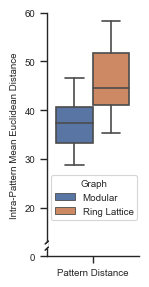

In [65]:
plot_rc = {'font.family': ['sans-serif'],
           'font.sans-serif': ['Arial'],
           'font.size': 7,
           'axes.titlesize': 7,
           'axes.labelsize': 7,
           'xtick.labelsize': 7,
           'ytick.labelsize': 7,
           'legend.fontsize': 7,
           'legend.title_fontsize': 7}
dfs = []
roi = 'loc-localized-both-600'
kind = 'mean-pattern'
comparison = 'pearson'

diag_dfs = []
modular_dists = np.zeros(16)
lattice_dists = np.zeros(15)
for node in range(15):
    for s, subject in enumerate(subjects['Modular']):
        pattern = load_block_avg_pattern(subject, roi, rescale=rescale, subtract_mean=subtract_mean)
        dists = cdist(pattern[:, node, :], pattern[:, node, :], metric='sqeuclidean')
        modular_dists[s] += dists[np.where(np.triu(np.ones((8, 8)), 1))].mean()
    for s, subject in enumerate(subjects['Lattice']):
        pattern = load_block_avg_pattern(subject, roi, rescale=rescale, subtract_mean=subtract_mean)
        dists = cdist(pattern[:, node, :], pattern[:, node, :], metric='sqeuclidean')
        lattice_dists[s] += dists[np.where(np.triu(np.ones((8, 8)), 1))].mean()
modular_dists /= (15 * len(subjects_modular))
lattice_dists /= (15 * len(subjects_lattice))
diag_dfs.append(pd.DataFrame(dict(dist=modular_dists, graph='Modular', roi=roi, kind='Pattern Distance')))
diag_dfs.append(pd.DataFrame(dict(dist=lattice_dists, graph='Lattice', roi=roi, kind='Pattern Distance')))
diag_df = pd.concat(diag_dfs)

sns.set()
sns.set_style("ticks")
sns.set_context("paper", rc=plot_rc)
axis_color = "#2B2B2B"

g2 = sns.catplot(data=(diag_df
                      .replace({'Lattice': 'Ring Lattice'})
                      .rename(columns={'graph': 'Graph'})
                     ),
                x='kind',
                y='dist',
                hue='Graph',
#                 row='comparison',
                legend_out=False,
                height=3,
                aspect=0.5,
                kind='box')
g2.set(title=None)
g2.set(xlabel=None)
g2.set(ylim=(10, 60))
g2.set(ylabel='Intra-Pattern Mean Euclidean Distance')
plt.legend(title='Graph', loc=(0.05, 0.15))
transAxes = g2.axes.flat[0].transAxes
# Add axis cut
g2.axes.flat[0].add_patch(Rectangle([-0.005, 0.035], 0.01, 0.02, edgecolor='white', alpha=1, facecolor="white", zorder=100, clip_on=False, transform=transAxes))
g2.axes.flat[0].add_patch(Rectangle([-0.02, 0.025], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
g2.axes.flat[0].add_patch(Rectangle([-0.02, 0.05], 0.04, 0.001, edgecolor=axis_color, alpha=1, facecolor=axis_color, zorder=101, clip_on=False, angle=20, transform=transAxes))
# And set bottom axis to 0
yticks = g2.axes.flat[0].get_yticks()
# yticks = np.concatenate(([0.03], yticks[2:]))
yticklabels = [f'{int(x)}' for x in yticks]
yticklabels[0] = '0'
g2.set(yticks=yticks)
g2.set(yticklabels=yticklabels)
# Save
g2.savefig('images/intrasubject_pattern_distance.pdf')

In [69]:
ttest_ind(diag_df[diag_df.graph == "Modular"]["dist"], diag_df[diag_df.graph == "Lattice"]["dist"])

Ttest_indResult(statistic=-3.597202314704651, pvalue=0.0011795585343102532)

In [72]:
print(f"dof = {len(diag_df) - 2}")

dof = 29
